In [1]:
#From https://photutils.readthedocs.io/en/stable/epsf.html

#purpose is to take HST images, identify, and get resolution from point sources (stars)

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

3.8.5


In [2]:
#the goal of this cell is to refine object coordinates from some initial guesses using either 2MASS or GAIA

#taking star coords from text file
star_coords = np.genfromtxt('hh6_star_coords.txt', dtype=str)

#setting up query
result_table = []
for i in star_coords:
    ra, dec = i
    result_table.append(Simbad.query_region(SkyCoord(ra+dec, frame='icrs'), radius='0d0m3s'))


In [3]:
#next, we load in some HST images

# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #can edit this accordingly or edit your file names
    #using s.lower() includes uppercase extensions like FIT
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

# #EX: grabbing all the fits image paths in a directory, #so they can be looped through and their data opened
# #set your path to some directory with images # (the images can be in subdirectories)
#the spitzer images
path = '../../n1333_photometry_ds9.bck.dir/**' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_spitz = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_spitz = [i.replace('\\', '/') for i in im_names_spitz]
im_names_spitz.remove('../../n1333_photometry_ds9.bck.dir/Frame20/n1333_band2_300_300_residual_hdrswap.fits')

#the hubble images
files_units = ['../../ngc1333_fits/126build_shift_2_drz.fits', 
                '../../ngc1333_fits/128build_shift_2_drz.fits', 
                '../../ngc1333_fits/164build_shift_2_drz.fits']

files_data = ['../../ngc1333_fits/126build_shift_2_drz.fits', 
                '../../ngc1333_fits/128build_shift_2_drz.fits', 
                '../../ngc1333_fits/164build_shift_2_drz.fits']

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []
# we ignore throughput since it is included (?) in the other conversion values I'm told
# throughput_list = [1., 1., 1., 1., 1., 1.] # [0.242, 1., 0.246, 0.496, 0.521, 0.470] #also has to be done by hand, not in the headers?

files_units = im_names_spitz + files_units
files_data = im_names_spitz + files_data

#opening data and headers
hdu_list_units = [fits.open(i) for i in files_units]
hdu_list = [fits.open(i) for i in files_data]

    
#I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
#the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
#I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
count = 0
for (hdu_units,hdu_data) in zip(hdu_list_units, hdu_list):
    if count < len(hdu_list)-3: #the spitzer ones
        #reading in conversions
        print(count, files_units[count])
        hdu_pix_list.append(hdu_units[0].header['CDELT2'])  #CDELT2 is the keyword for Spitzer images, in arcsec
        hdu_pixtorad_list.append(hdu_pix_list[count] * np.pi / 180.) #convert to radians
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        # hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
#         hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in datafor general use  and header for wcs
        #the spiter data is in MJy / sr, so let's convert out the MJy to Flam units, times by bw/calscale from earlier
        #this gets units of erg/cm^2/sec - we also times by 1 rad^2 - 1 sr!  
        hdu_data_list.append(hdu_data[0].data * 1e6 * 1e-23 * hdu_pixtorad_list[count]**2.)  
        hdu_header_list.append(hdu_data[0].header)
        
    else: #the hubble ones
        #reading in conversions
        hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
        hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
        hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in data for general use  and header for wcs
        #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
        hdu_data_list.append(hdu_data[1].data * hdu_units[0].header['PHOTFLAM'] * hdu_units[0].header['PHOTBW'])
        print(hdu_units[0].header['PHOTFLAM'], hdu_units[0].header['PHOTBW'])
        hdu_header_list.append(hdu_data[1].header)

    count += 1

print('loaded data!')


0 ../../n1333_photometry_ds9.bck.dir/Frame1/n1333_lh_3_FeII_flag400_2_map_fixed.FIT
1 ../../n1333_photometry_ds9.bck.dir/Frame10/n1333_sh_1_S32_map.fits
2 ../../n1333_photometry_ds9.bck.dir/Frame11/n1333_sh_NeII_2_map.fits
3 ../../n1333_photometry_ds9.bck.dir/Frame12/n1333_sh_S2_2_map.fits
4 ../../n1333_photometry_ds9.bck.dir/Frame13/n1333_sl1_NeII_bksub_trim_2_map.fits
5 ../../n1333_photometry_ds9.bck.dir/Frame14/n1333_sl1_S2_bksub_trim_2_map.fits
6 ../../n1333_photometry_ds9.bck.dir/Frame15/n1333_sl1_S3_bksub_trim_2_map_fixed1.FIT
7 ../../n1333_photometry_ds9.bck.dir/Frame16/n1333_sl1_S4_bksub_trim_3_map.fits
8 ../../n1333_photometry_ds9.bck.dir/Frame17/n1333_sl2_S5_bksub_trim_2_map.fits
9 ../../n1333_photometry_ds9.bck.dir/Frame18/n1333_sl2_S6_bksub_trim_3_map.fits
10 ../../n1333_photometry_ds9.bck.dir/Frame19/n1333_sl2_S7_bksub_trim_2_map.fits
11 ../../n1333_photometry_ds9.bck.dir/Frame2/n1333_lh_3_S0_flag400_2_map_fixed.FIT
12 ../../n1333_photometry_ds9.bck.dir/Frame3/n1333_lh_3_S

In [4]:
#follow https://photutils.readthedocs.io/en/stable/epsf.html

#now, locate spots on the images
from astropy.nddata import NDData
nddata = NDData(data=hdu_data_list[-1], wcs=WCS(hdu_header_list[-1]))   #here reformatting data from 1.64 micron HST image

from astropy.table import Table
from astropy.wcs.utils import skycoord_to_pixel
from photutils.psf import extract_stars #use this to make star cutouts

#this was made complicated bc you cannot directly go from skycoord to Table
stars_tbl = Table(names=('x', 'y'))
for i in range(len(result_table)):
    ra_dec_formatted = SkyCoord(result_table[i]['RA'][0] + ' ' + result_table[i]['DEC'][0], frame='icrs', unit=(u.hourangle, u.deg))
    pix = skycoord_to_pixel(ra_dec_formatted, WCS(hdu_header_list[-1]))

    stars_tbl.add_row(pix)
stars = extract_stars(nddata, stars_tbl, size=25) 

C:\Users\arubi\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


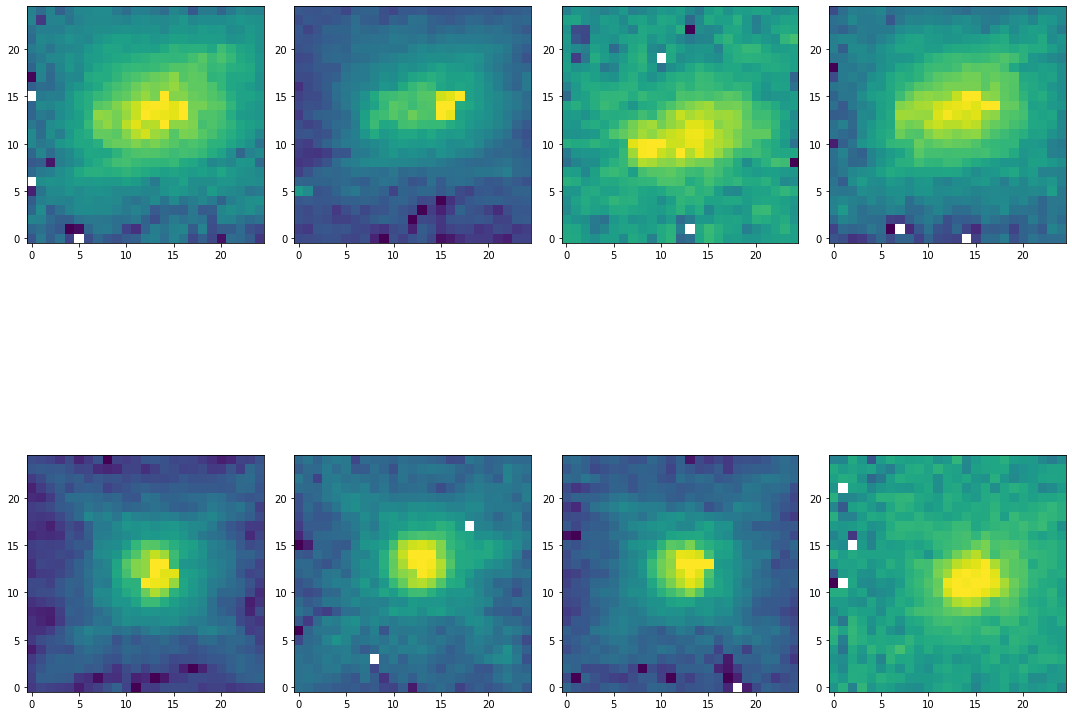

In [5]:
#finally, make psfs for each star and then we determine the resolution from the PSFs
#can be done by fitting a gaussian (or other kernel) and normalizing so integral of psf is 1

import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

plt.tight_layout()

C:\Users\arubi\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


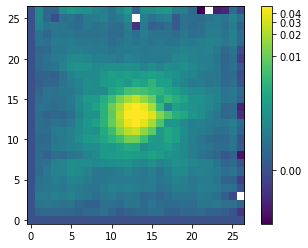

In [6]:
#attempting and failing to make an effective psf fitter

#increase maxiters to smooth more and decrease oversampling to avoid issues 
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=1, maxiters=30,
                           progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars[4:])  

import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

<ipython-input-23-d0b0bcfb0ba0>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1,0].pcolormesh(x, y, epsf.data)


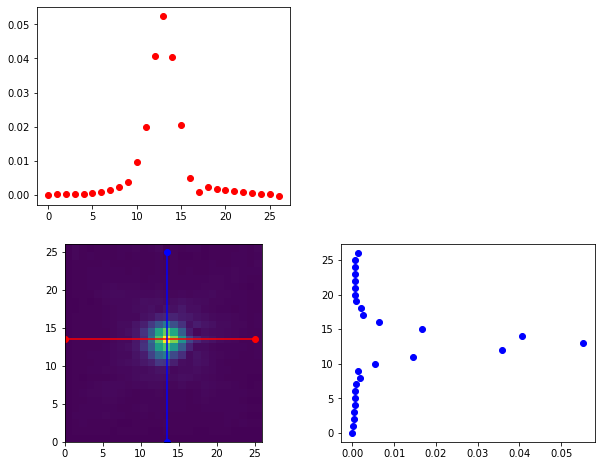

In [23]:
#https://photutils.readthedocs.io/en/stable/psf_matching.html could be inspiration
#https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-12.pdf can see for more...

#instead let's double check stackoverflow for now...seems complex
#ultimately just trying epsf cross section, like in https://stackoverflow.com/questions/18920614/plot-cross-section-through-heat-map

# Coordinates of the line we'd like to sample along
line = [(0, 13.5), (25, 13.5)]

# Convert the line to pixel/index coordinates
x, y = np.arange(epsf.data.shape[0]), np.arange(epsf.data.shape[1])
x_world, y_world = np.array(list(zip(*line)))
col = epsf.data.shape[1] * (x_world - x.min()) / x.ptp()
row = epsf.data.shape[0] * (y_world - y.min()) / y.ptp()

# Interpolate the line at "num" points...
num = 27
row, col = [np.linspace(item[0], item[1], num) for item in [row, col]]

# Plot...
fig, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
fig.delaxes(axes[0,1])

axes[1,0].pcolormesh(x, y, epsf.data)
axes[1,0].plot(x_world, y_world, 'ro-')
axes[1,0].plot(y_world, x_world, 'bo-')
axes[1,0].axis('image')

# Extract the values along the line, using cubic interpolation
import scipy as sp
#horizontal cut
cross_sec_hori = sp.ndimage.map_coordinates(epsf.data, np.vstack((row, col)))
axes[0,0].scatter(np.arange(len(cross_sec_hori)), cross_sec_hori, color='r')

#vertical cut
cross_sec_vert = sp.ndimage.map_coordinates(epsf.data, np.vstack((col, row)))

axes[1,1].scatter(cross_sec_vert, np.arange(len(cross_sec_vert)), color='b')

plt.show()

In [8]:
'''
This shows it is about 3 to 4 pixels wide for FWHM (haven't directly measured yet)

theta as in res is 1.2 * lambda / D
If we take 1.64 microns and 2.4e6 meters, then we get an angular res of 
1.319e-6 radians ?
Ok so we can use pixtorad of 6.217729758370198e-07 rads = 1 pix
So we therefore divide to get 2.12 pixels

So the 2.12 is perhaps a slight underestimate? Depends on the specifics of this model and the cross section, though
'''

"\nThis shows it is about 3 to 4 pixels wide for FWHM (haven't directly measured yet)\n\ntheta as in res is 1.2 * lambda / D\nIf we take 1.64 microns and 2.4e6 meters, then we get an angular res of \n1.319e-6 radians ?\nOk so we can use pixtorad of 6.217729758370198e-07 rads = 1 pix\nSo we therefore divide to get 2.12 pixels\n\nSo the 2.12 is perhaps a slight underestimate? Depends on the specifics of this model and the cross section, though\n"